In [34]:
# Test align_single_exposures
# Case 1: toy example
# Case 2: sdss data

import numpy as np
import galsim
import torch
import torch.nn.functional as F
from bliss.models.decoder import get_mgrid
from bliss.datasets.galsim_galaxies import GalsimBlends
import matplotlib.pyplot as plt
from hydra import compose, initialize
from hydra.utils import instantiate
from torch import Tensor
from typing import Dict, Optional
import pytorch_lightning as pl
from einops import rearrange
from torch.utils.data import DataLoader, Dataset
from bliss.catalog import TileCatalog, get_is_on_from_n_sources, FullCatalog
from bliss.datasets.background import ConstantBackground
from bliss.datasets.sdss import convert_flux_to_mag
from bliss.models.galsim_decoder import (
    SingleGalsimGalaxyDecoder,
    SingleGalsimGalaxyPrior,
    UniformGalsimGalaxiesPrior,
)

from case_studies.coadds.signal_noise_ratio import snr
from case_studies.coadds.align_single_exposures import align_single_exposures

In [2]:
def render_galaxy(
    self,
    galaxy_params: Tensor,
    psf: galsim.GSObject,
    slen: int,
    offset: Optional[Tensor] = None,
    dithers: Optional[Tensor] = None,
) -> Tensor:
    assert offset is None or offset.shape == (2,)
    if isinstance(galaxy_params, Tensor):
        galaxy_params = galaxy_params.cpu().detach()
    total_flux, disk_frac, beta_radians, disk_q, a_d, bulge_q, a_b = galaxy_params
    bulge_frac = 1 - disk_frac

    disk_flux = total_flux * disk_frac
    bulge_flux = total_flux * bulge_frac

    components = []
    if disk_flux > 0:
        b_d = a_d * disk_q
        disk_hlr_arcsecs = np.sqrt(a_d * b_d)
        disk = galsim.Exponential(flux=disk_flux, half_light_radius=disk_hlr_arcsecs).shear(
            q=disk_q,
            beta=beta_radians * galsim.radians,
        )
        components.append(disk)
    if bulge_flux > 0:
        b_b = bulge_q * a_b
        bulge_hlr_arcsecs = np.sqrt(a_b * b_b)
        bulge = galsim.DeVaucouleurs(flux=bulge_flux, half_light_radius=bulge_hlr_arcsecs).shear(
            q=bulge_q, beta=beta_radians * galsim.radians
        )
        components.append(bulge)
    galaxy = galsim.Add(components)
    gal_conv = galsim.Convolution(galaxy, psf)
    offset = (0, 0) if offset is None else offset
    dithers = (0, 0) if dithers is None else dithers
    shift = torch.add(torch.Tensor(dithers), torch.Tensor(offset))
    shift = shift.reshape(1, 2) if len(shift) == 2 else shift
    images = []
    for i in shift:
        image = gal_conv.drawImage(
            nx=slen, ny=slen, method="auto", scale=self.pixel_scale, offset=i
        )
        image = image.array
        images.append(image)
    return torch.tensor(images[:]).reshape(len(shift), 1, slen, slen)

In [35]:
%load_ext autoreload
%autoreload 2
%aimport
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Modules to reload:
all-except-skipped

Modules to skip:



In [ ]:
# Case 1: toy example

In [8]:
# Create initial image I0
pixel_scale = 0.393
slen = 10

# create base wcs
g0 = galsim.Gaussian(sigma=1.0)
g0 = g0.shear(e1=0, e2=0)
img0 = g0.drawImage(nx=slen, ny=slen, scale=pixel_scale)

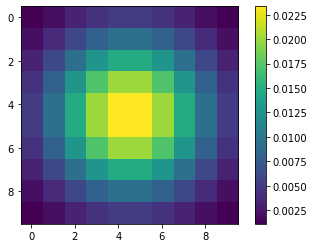

In [9]:
img0 = img0.array
plt.figure()
plt.imshow(img0)
plt.colorbar()

/tmp/ipykernel_924984/4111949874.py:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)
  images = torch.tensor(images[:]).reshape(len(dithers), 1, slen, slen)


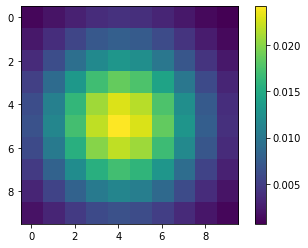

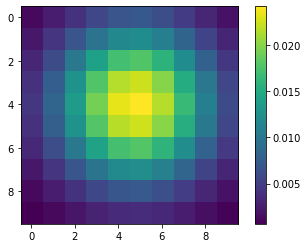

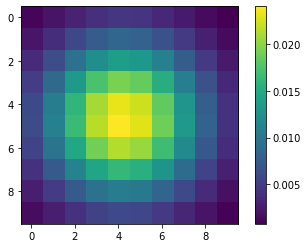

In [10]:
# create dithers
n = 3
dithers = [((-0.5 - 0.5) * torch.rand((2,)) + 0.5).numpy() for x in range(n)]

# this is the same code as from render_galaxy (minus the plots)
images = []
for i in dithers:
    image = g0.drawImage(nx=slen, ny=slen, method="auto", scale=pixel_scale, offset=i)
    image = image.array

    plt.figure()
    plt.imshow(image)
    plt.colorbar()

    images.append(image)
images = torch.tensor(images[:]).reshape(len(dithers), 1, slen, slen)

In [14]:
aligned_images = align_single_exposures(img0, images, slen, dithers)
aligned_images.shape

/home/wmallory/bliss/case_studies/coadds/align_single_exposures.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [grid, torch.stack((torch.tensor(x_grid), torch.tensor(y_grid)), -1)], dim=0
/home/wmallory/bliss/case_studies/coadds/align_single_exposures.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input = torch.tensor(images[:]).reshape(len(dithers), 1, slen, slen).float()
/home/wmallory/bliss/case_studies/coadds/align_single_exposures.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  interped_images = torch.tensor(interped

torch.Size([3, 8, 8])

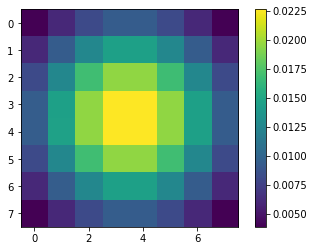

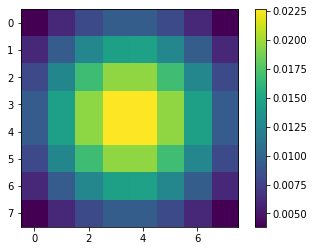

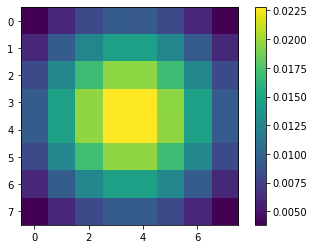

In [12]:
for i in range(len(dithers)):
    plt.figure()
    plt.imshow(aligned_images[i])
    plt.colorbar()

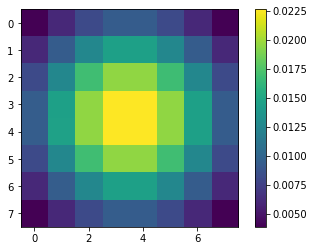

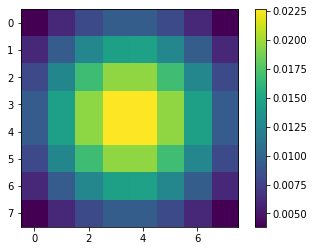

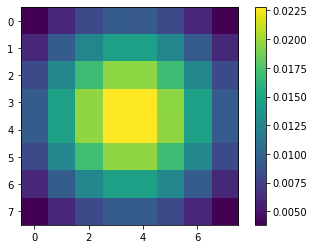

In [15]:
for i in range(len(dithers)):
    plt.figure()
    plt.imshow(aligned_images[i])
    plt.colorbar()

In [ ]:
# Case 2: sdss data

In [36]:
with initialize(config_path="../sdss_galaxies/config"):
    cfg = compose("config", overrides=[])

In [37]:
decoder = instantiate(cfg.datasets.sdss_galaxies.decoder)
psf = decoder.psf
prior = instantiate(cfg.datasets.galsim_blended_galaxies.prior)
decoder = instantiate(cfg.datasets.galsim_blended_galaxies.decoder)
background = instantiate(cfg.datasets.galsim_blended_galaxies.background)
tile_slen = 4
max_tile_n_sources = 1
num_workers = 5
batch_size = 1000
n_batches = 1
full_catalog = GalsimBlends(
    prior=prior,
    decoder=decoder,
    background=background,
    tile_slen=tile_slen,
    max_sources_per_tile=max_tile_n_sources,
    num_workers=num_workers,
    batch_size=batch_size,
    n_batches=n_batches,
)._sample_full_catalog()

In [38]:
size = decoder.slen + 2 * decoder.bp
full_plocs = full_catalog.plocs
b, max_n_sources, _ = full_plocs.shape

image = torch.zeros(len(dithers), 1, size, size)
image0 = torch.zeros(1, 1, size, size)
noiseless_centered = torch.zeros(len(dithers), max_n_sources, 1, size, size)
noiseless_uncentered = torch.zeros(len(dithers), max_n_sources, 1, size, size)

n_sources = int(full_catalog.n_sources[0].item())
galaxy_params = full_catalog["galaxy_params"][0]
plocs = full_plocs[0]

offset_x = plocs[0][1] + decoder.bp - size / 2
offset_y = plocs[0][0] + decoder.bp - size / 2
offset = torch.tensor([offset_x, offset_y])
decoder = instantiate(cfg.datasets.sdss_galaxies.decoder)
uncentered = render_galaxy(decoder, galaxy_params[0], psf, size, offset)
uncentered_dithered = render_galaxy(decoder, galaxy_params[0], psf, size, offset, dithers)

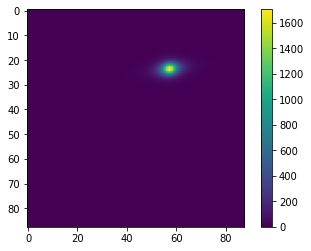

In [39]:
plt.figure()
plt.imshow(uncentered.reshape(size, size))
plt.colorbar()

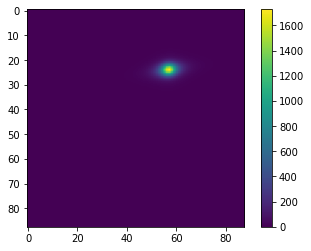

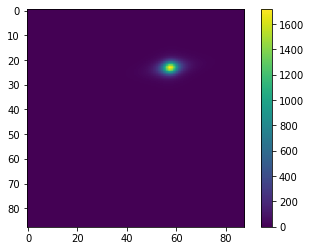

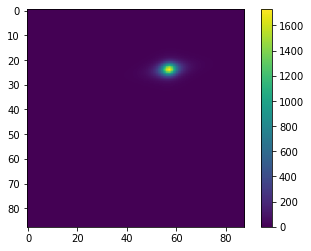

In [40]:
# hard to tell the dithers
for i in range(len(dithers)):
    plt.figure()
    plt.imshow(uncentered_dithered.reshape(len(dithers), size, size)[i])
    plt.colorbar()

In [41]:
# now the data is like the output from render_catalog with only one source
img0 = uncentered.reshape(size, size)
images = uncentered_dithered

In [42]:
aligned_images = align_single_exposures(img0, images, size, dithers)
aligned_images.shape  # the output should be cropped

/home/wmallory/bliss/case_studies/coadds/align_single_exposures.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [grid, torch.stack((torch.tensor(x_grid), torch.tensor(y_grid)), -1)], dim=0
/home/wmallory/bliss/case_studies/coadds/align_single_exposures.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input = torch.tensor(images[:]).reshape(len(dithers), 1, slen, slen).float()
/home/wmallory/bliss/case_studies/coadds/align_single_exposures.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  interped_images = torch.tensor(interped

torch.Size([3, 86, 86])

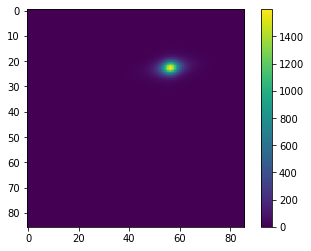

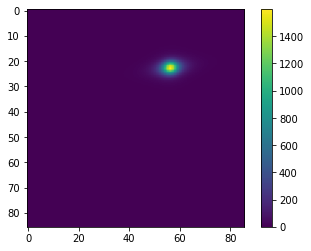

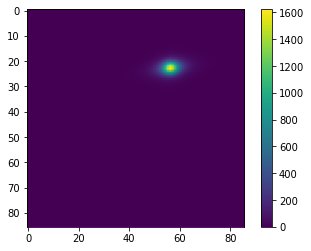

In [43]:
# still hard to tell the dithers
for i in range(len(dithers)):
    plt.figure()
    plt.imshow(aligned_images[i])
    plt.colorbar()